In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dish-network-hackathon/Sample_Submission.csv
/kaggle/input/dish-network-hackathon/Data_Dictionary.csv
/kaggle/input/dish-network-hackathon/Train_Dataset.csv
/kaggle/input/dish-network-hackathon/Test_Dataset.csv


In [2]:
# 1. General Utilities & Data Handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Preprocessing & Splitting
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample, compute_class_weight

# 3. Individual Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# 4. Ensemble Methods
from sklearn.ensemble import VotingClassifier, StackingClassifier

# 5. Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

#6. Add Ons ~ Misc
import random
# =========================
import warnings
from sklearn.feature_selection import mutual_info_classif

# =========================
# 2. Suppress Non-Critical Warnings
# =========================
warnings.filterwarnings(
    "ignore",
    category=UserWarning
)

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning
)

warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

In [3]:
df = pd.read_csv('/kaggle/input/dish-network-hackathon/Train_Dataset.csv', low_memory=False)
df.head(10)

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552795,0.329655054,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,...,Yes,Yes,XNA,NaN,0.135182,0.631354537,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,...,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355638717,0.2021,674.0,1.0,0
5,12191614,11250,0.0,1.0,1.0,1.0,1.0,13752,653.85,Alone,...,Yes,Yes,Other,NaN,0.697928,0.420610964,0.0639,739.0,0.0,0
6,12128086,15750,1.0,1.0,0.0,1.0,0.0,128835,3779.55,Alone,...,Yes,Yes,XNA,0.729913,0.602545,0.511891802,0.2041,0.0,3.0,0
7,12215264,13500,0.0,0.0,1.0,1.0,0.0,60415.2,3097.8,Alone,...,Yes,Yes,XNA,0.711468,0.657508,0.549596502,NaN,1687.0,4.0,0
8,12159147,13500,1.0,1.0,0.0,1.0,1.0,45000,1200.15,Relative,...,Yes,Yes,Self-employed,0.475727,0.637594,0.553164699,0.1670,1611.0,0.0,0
9,12130547,12150,0.0,0.0,0.0,1.0,0.0,16320.15,1294.65,Alone,...,Yes,Yes,XNA,0.682285,0.063343,0.080649544,NaN,533.0,5.0,0


In [4]:
df.groupby(['Default'])['ID'].nunique() #Imbalanced DataSet

Default
0    112011
1      9845
Name: ID, dtype: int64

In [5]:
df.dtypes

ID                              int64
Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Famil

In [6]:
df.isnull().sum()

ID                                0
Client_Income                  3607
Car_Owned                      3581
Bike_Owned                     3624
Active_Loan                    3635
House_Own                      3661
Child_Count                    3638
Credit_Amount                  3632
Loan_Annuity                   4812
Accompany_Client               1746
Client_Income_Type             3701
Client_Education               3645
Client_Marital_Status          3473
Client_Gender                  2413
Loan_Contract_Type             3651
Client_Housing_Type            3687
Population_Region_Relative     4857
Age_Days                       3600
Employed_Days                  3649
Registration_Days              3614
ID_Days                        5968
Own_House_Age                 80095
Mobile_Tag                        0
Homephone_Tag                     0
Workphone_Working                 0
Client_Occupation             41435
Client_Family_Members          2410
Cleint_City_Rating          

In [7]:
# Clean and convert 'Client_Income' column to numeric
df['Client_Income'] = pd.to_numeric(df['Client_Income'], errors='coerce')

# Clean and convert 'Credit_Amount' column to numeric
df['Credit_Amount'] = df['Credit_Amount'].str.replace('[^0-9.]', '', regex=True)
df['Credit_Amount'] = pd.to_numeric(df['Credit_Amount'], errors='coerce')
df['Credit_Amount'] = pd.to_numeric(df['Credit_Amount'], errors='coerce')

# Clean and convert 'Loan_Annuity' column to numeric
df['Loan_Annuity'] = df['Loan_Annuity'].str.replace('[^0-9.]', '', regex=True)
df['Loan_Annuity'] = pd.to_numeric(df['Loan_Annuity'], errors='coerce')

# Clean and convert 'Population_Region_Relative' column to numeric
df['Population_Region_Relative'] = df['Population_Region_Relative'].str.replace('[^0-9.]', '', regex=True)
df['Population_Region_Relative'] = pd.to_numeric(df['Population_Region_Relative'], errors='coerce')

# Clean and convert 'Age_Days' column to numeric
df['Age_Days'] = df['Age_Days'].str.replace('[^0-9.]', '', regex=True)
df['Age_Days'] = pd.to_numeric(df['Age_Days'], errors='coerce')

# Clean and convert 'Employed_Days' column to numeric
df['Employed_Days'] = df['Employed_Days'].str.replace('[^0-9.]', '', regex=True)
df['Employed_Days'] = pd.to_numeric(df['Employed_Days'], errors='coerce')

# Clean and convert 'Registration_Days' column to numeric
df['Registration_Days'] = df['Registration_Days'].str.replace('[^0-9.]', '', regex=True)
df['Registration_Days'] = pd.to_numeric(df['Registration_Days'], errors='coerce')

# Clean and convert 'Score_Source_3' column to numeric
df['Score_Source_3'] = df['Score_Source_3'].str.replace('[^0-9.]', '', regex=True)
df['Score_Source_3'] = pd.to_numeric(df['Score_Source_3'], errors='coerce')

# Check the the data types of each column again
df.dtypes

ID                              int64
Client_Income                 float64
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative    float64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Famil

In [8]:
# List of column names representing numerical data features
numerical_data = ["ID", "Client_Income", "Car_Owned", "Bike_Owned", "Active_Loan", "House_Own", "Child_Count",
                  "Credit_Amount", "Loan_Annuity", "Population_Region_Relative", "Age_Days", "Employed_Days", "Registration_Days",
                  "ID_Days", "Own_House_Age", "Mobile_Tag","Homephone_Tag", "Workphone_Working", "Client_Family_Members", 
                   "Cleint_City_Rating", "Application_Process_Day", "Application_Process_Hour", "Score_Source_1",
                   "Score_Source_2", "Score_Source_3", "Social_Circle_Default", "Phone_Change", "Credit_Bureau"]

# List of column names representing categorical data features
categorical_data = ["Accompany_Client", "Client_Income_Type", "Client_Education", "Client_Marital_Status", "Client_Gender",
                    "Loan_Contract_Type", "Client_Housing_Type", "Client_Occupation", "Client_Permanent_Match_Tag", 
                     "Client_Contact_Work_Tag", 
                     "Type_Organization"]


In [9]:
print(numerical_data)

['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age', 'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Family_Members', 'Cleint_City_Rating', 'Application_Process_Day', 'Application_Process_Hour', 'Score_Source_1', 'Score_Source_2', 'Score_Source_3', 'Social_Circle_Default', 'Phone_Change', 'Credit_Bureau']


In [10]:
# Print the value counts of each unique value in the column
for i in categorical_data:
    print(df[i].value_counts())
    print('-' * 50)

Accompany_Client
Alone       97409
Relative    15748
Partner      4516
Kids         1334
Others        987
Group         104
##             12
Name: count, dtype: int64
--------------------------------------------------
Client_Income_Type
Service            61028
Commercial         27764
Retired            21043
Govt Job            8303
Student                8
Unemployed             6
Maternity leave        2
Businessman            1
Name: count, dtype: int64
--------------------------------------------------
Client_Education
Secondary             83911
Graduation            28819
Graduation dropout     3960
Junior secondary       1455
Post Grad                66
Name: count, dtype: int64
--------------------------------------------------
Client_Marital_Status
M    87349
S    17404
D     7556
W     6074
Name: count, dtype: int64
--------------------------------------------------
Client_Gender
Male      78463
Female    40977
XNA           3
Name: count, dtype: int64
-------------------

In [11]:
# Define a mapping dictionary to combine the clusters
cluster_mapping = {"Student":"Govt Job", "Unemployed":"Govt Job" ,"Maternity leave":"Govt Job", "Businessman":"Govt Job"}

# Update the "Client_Income_Type" column with the new cluster labels
df["Client_Income_Type"] = df["Client_Income_Type"].replace(cluster_mapping)

# Check the value_counts after replacing
print(df["Client_Income_Type"].value_counts())

# Define a mapping dictionary to combine the clusters
cluster_mapping = {"Post Grad":"Junior secondary"}

# Update the "Client_Income_Type" column with the new cluster labels
df["Client_Education"] = df["Client_Education"].replace(cluster_mapping)

# Check the value_counts after replacing
print(df["Client_Education"].value_counts())

# Create a boolean mask to identify rows where "Client_Gender" is "XNA"
mask = df["Client_Gender"] == "XNA"

# Use the mask to drop the corresponding rows
df.drop(df[mask].index, inplace=True)

# Print the value counts of the "Client_Gender" column after removal
print(df['Client_Gender'].value_counts())

# Define a mapping dictionary to combine the clusters
cluster_mapping = {"##" : "Others", "Group" : "Others"}

# Update the "Accompany_Client" column with the new cluster labels
df["Accompany_Client"] = df["Accompany_Client"].replace(cluster_mapping)

# Check the value_counts after replacing
print(df["Accompany_Client"].value_counts())

Client_Income_Type
Service       61028
Commercial    27764
Retired       21043
Govt Job       8320
Name: count, dtype: int64
Client_Education
Secondary             83911
Graduation            28819
Graduation dropout     3960
Junior secondary       1521
Name: count, dtype: int64
Client_Gender
Male      78463
Female    40977
Name: count, dtype: int64
Accompany_Client
Alone       97407
Relative    15747
Partner      4516
Kids         1334
Others       1103
Name: count, dtype: int64


In [12]:
filtered_df = df[df.applymap(lambda x: isinstance(x, str) and 'x' in x).any(axis=1)]
filtered_df

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
16335,12182976,7650.0,0.0,1.0,1.0,1.0,0.0,9669.6,483.30,Alone,...,Yes,Yes,Business Entity Type 2,0.391044,0.622292,0.194068,NaN,547.0,5.0,0
30043,12193379,13500.0,0.0,0.0,0.0,0.0,0.0,94230.0,2754.90,Alone,...,Yes,Yes,Transport: type 4,0.745922,0.779345,0.736623,0.4268,3288.0,2.0,0
35293,12188608,14400.0,0.0,0.0,0.0,1.0,0.0,102202.2,4342.95,Alone,...,Yes,Yes,XNA,NaN,0.386343,NaN,NaN,1002.0,NaN,0
49802,12137970,11250.0,1.0,1.0,0.0,1.0,1.0,6750.0,553.95,Alone,...,Yes,No,Business Entity Type 1,NaN,0.481226,0.600658,NaN,0.0,0.0,0
50492,12162008,45000.0,0.0,0.0,0.0,1.0,0.0,131211.0,4875.30,Alone,...,No,Yes,Business Entity Type 3,NaN,0.489135,0.067794,0.0515,832.0,0.0,0
52724,12168302,18900.0,0.0,0.0,0.0,1.0,0.0,59256.0,3115.35,Alone,...,Yes,Yes,School,NaN,0.759379,NaN,NaN,464.0,1.0,0
59383,12120552,NaN,0.0,0.0,0.0,1.0,0.0,45000.0,2719.35,Alone,...,Yes,Yes,Business Entity Type 3,NaN,0.673944,0.350696,0.1206,1585.0,5.0,0
66390,12136418,12150.0,0.0,1.0,0.0,1.0,0.0,100956.6,3349.35,Alone,...,Yes,Yes,XNA,NaN,0.799336,NaN,0.0742,2029.0,3.0,1
70325,12162067,18000.0,0.0,0.0,0.0,1.0,2.0,14220.0,963.00,Alone,...,Yes,Yes,Medicine,NaN,0.693446,0.846378,0.1552,78.0,0.0,0
72965,12164158,31500.0,0.0,0.0,0.0,1.0,0.0,59256.0,3227.40,Alone,...,Yes,Yes,Self-employed,0.216824,0.522478,0.332851,0.0495,99.0,2.0,0


In [13]:
# Create a boolean mask to identify rows where "ID_Days" is equal to "x"
mask = df["ID_Days"] == "x"

# Replace the corresponding rows with NaN
df.loc[mask, "ID_Days"] = np.nan

In [14]:
df.dtypes

ID                              int64
Client_Income                 float64
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative    float64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Famil

In [15]:
for col in df:
  if df[col].dtype in [int,float]:
    mean_val = df[col].mean()
    df[col].fillna(mean_val,inplace=True)

In [16]:
df.dropna(inplace=True)


from sklearn.preprocessing import OrdinalEncoder
label_encoder = OrdinalEncoder()

for i in categorical_data:
    df[i] = label_encoder.fit_transform(df[i].astype(str).values.reshape(-1,1))


scaler = StandardScaler()
df[numerical_data] = scaler.fit_transform(df[numerical_data])


df.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,-0.524638,-1.002171,-0.798370,-0.713363,1.022450,-1.47814,-0.660120,0.002746,0.436977,0.0,...,1.0,1.0,42.0,0.541720,-0.052497,0.047861,-1.299835,-1.115849,0.018311,0
2,0.580621,0.045646,-0.798370,-0.713363,1.022450,-1.47814,0.656647,-0.038822,0.001839,0.0,...,1.0,1.0,42.0,0.071933,0.037419,-1.005115,-0.569892,-0.854172,-1.104117,0
4,-0.784847,1.512590,1.289779,-0.713363,1.022450,-1.47814,1.973414,1.822144,0.527306,0.0,...,1.0,1.0,5.0,0.121029,-0.268279,-0.854397,1.109239,-0.368723,-0.510557,0
5,0.875794,-0.583044,-0.798370,1.445550,1.022450,0.69702,0.656647,-1.182861,-1.475512,0.0,...,1.0,1.0,33.0,0.071933,0.213749,-0.477528,-0.705115,-0.289242,-1.104117,0
8,-0.050137,-0.373481,1.289779,1.445550,-1.008202,0.69702,0.656647,-0.401896,-1.097375,4.0,...,1.0,1.0,42.0,-0.107153,0.140446,0.291347,0.648430,0.777032,-1.104117,0


In [17]:
df.shape

(61579, 40)

In [18]:
df['Default'] = df['Default'].astype(int) 

df.dtypes

ID                            float64
Client_Income                 float64
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client              float64
Client_Income_Type            float64
Client_Education              float64
Client_Marital_Status         float64
Client_Gender                 float64
Loan_Contract_Type            float64
Client_Housing_Type           float64
Population_Region_Relative    float64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                       float64
Own_House_Age                 float64
Mobile_Tag                    float64
Homephone_Tag                 float64
Workphone_Working             float64
Client_Occupation             float64
Client_Famil

In [19]:
df.isnull().sum()

ID                            0
Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Own_House_Age                 0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Occupation             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_C

Evaluating Weighted Models vs. Ensembles...
Finished evaluating: Logistic Regression (W)
Finished evaluating: Naive Bayes
Finished evaluating: Random Forest (W)
Finished evaluating: XGBoost (W)
Finished evaluating: Hard Voting (RF+XGB+NB)
Finished evaluating: Soft Voting (RF+XGB+NB)
Finished evaluating: Stacking (RF+XGB+NB)

--- Final Performance Comparison ---


,Model,Avg Accuracy,Avg Precision,Avg Recall,Avg F1,Avg ROC-AUC
2,Random Forest (W),0.691860,0.697498,0.677674,0.687350,0.754406
6,Stacking (RF+XGB+NB),0.686977,0.687654,0.685349,0.686234,0.748890
5,Soft Voting (RF+XGB+NB),0.681628,0.676446,0.696279,0.686131,0.747355
4,Hard Voting (RF+XGB+NB),0.690116,0.705764,0.652093,0.677740,0.690116
3,XGBoost (W),0.672093,0.672124,0.672326,0.672134,0.733615
0,Logistic Regression (W),0.672558,0.675187,0.665116,0.670100,0.732903
1,Naive Bayes,0.643605,0.639245,0.659302,0.649093,0.693069


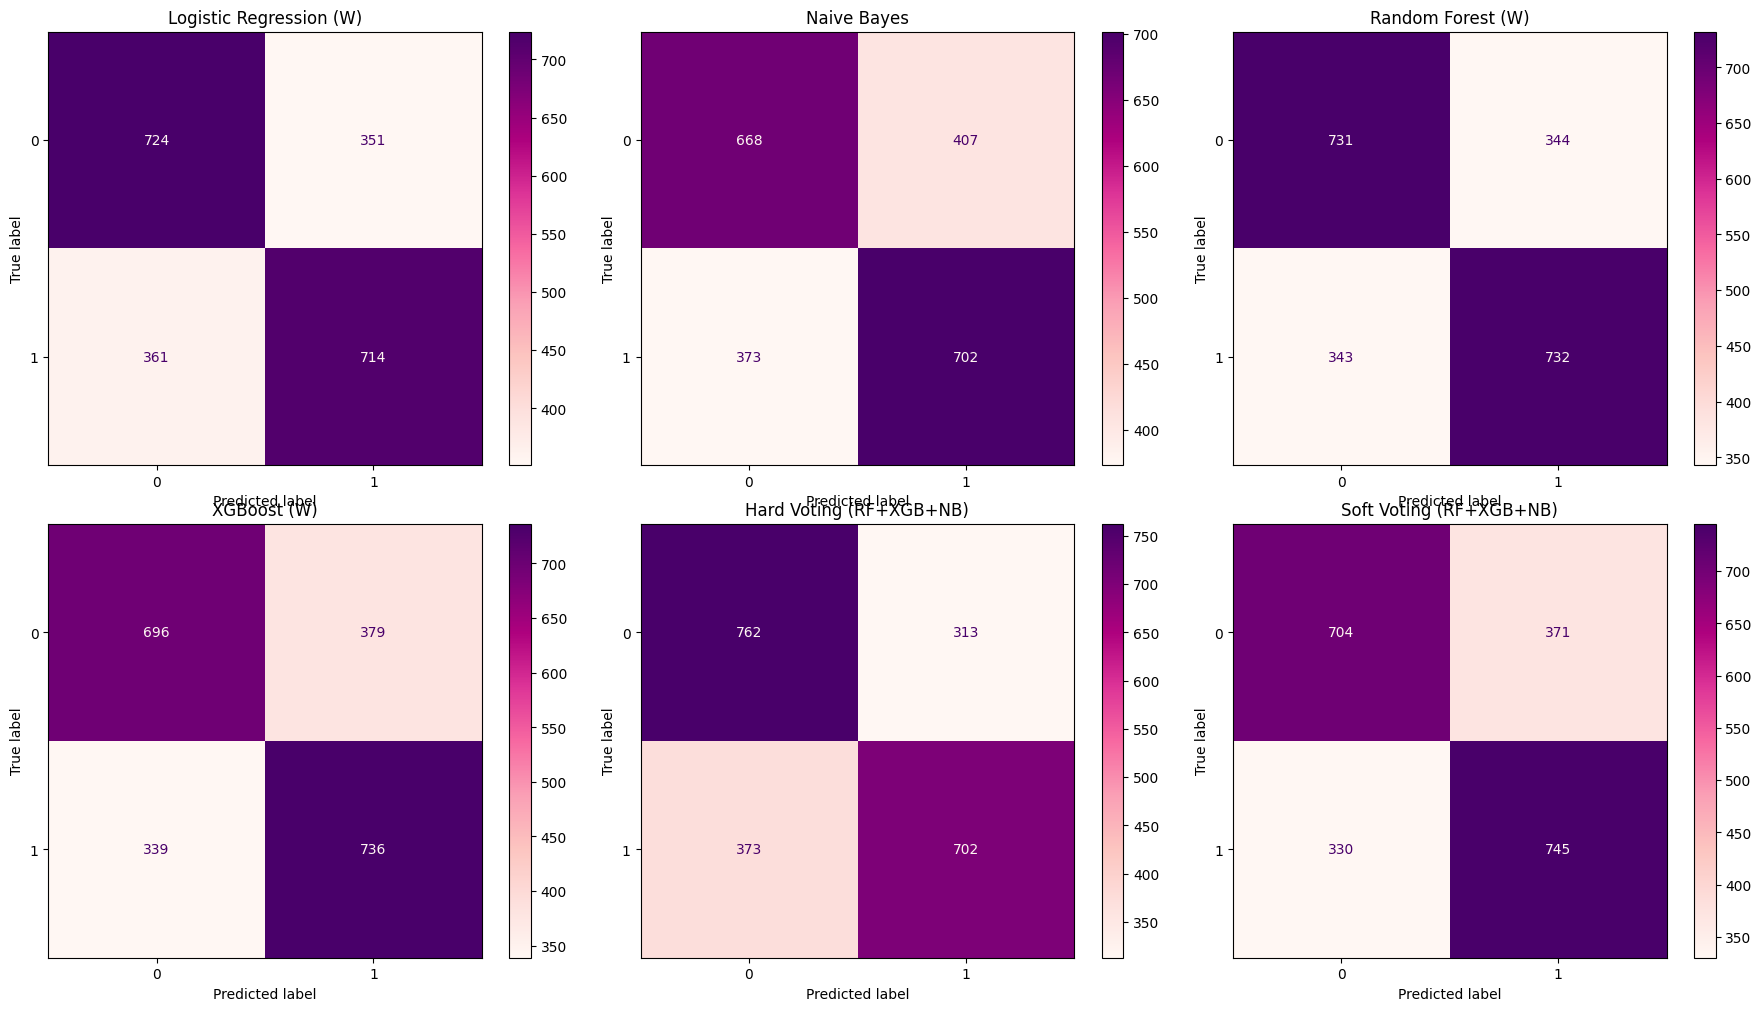

In [20]:
# Initial Split: Separate Majority and Minority from the WHOLE dataset
df_maj_all = df[df.Default == 0]
df_min_all = df[df.Default == 1]

# Create the Training Pool 
df_min_train_pool = df_min_all 
df_maj_train_pool = df_maj_all

# Downsample the Training Pool to make it balanced
df_maj_downsampled = resample(df_maj_train_pool, 
                              replace=False, 
                              n_samples=len(df_min_train_pool), 
                              random_state=42)

# Combine to create the Balanced Training Set
df_balanced = pd.concat([df_maj_downsampled, df_min_train_pool]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Default', 'ID'], axis=1) 
y = df_balanced['Default']

X_train_full, X_test, y_train_full, y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



lr_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
nb_model = GaussianNB()
rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
xgb_weighted = XGBClassifier(
    random_state=42, 
    eval_metric='logloss', 
    scale_pos_weight=(len(y_train_full[y_train_full==0]) / len(y_train_full[y_train_full==1]))
)


models = {
    "Logistic Regression (W)": lr_weighted,
    "Naive Bayes": nb_model,
    "Random Forest (W)": rf_weighted,
    "XGBoost (W)": xgb_weighted,
    
    # Voting: Averages the y_probs of RF and NB
    "Hard Voting (RF+XGB+NB)": VotingClassifier(
        estimators=[('rf', rf_weighted),('xgb', xgb_weighted),('nb', nb_model)],
        voting='hard', weights=[3,1,2]
    ),

     # Voting: Averages the y_probs of RF and NB
    "Soft Voting (RF+XGB+NB)": VotingClassifier(
        estimators=[('rf', rf_weighted),('xgb', xgb_weighted),('nb', nb_model)],
        voting='soft', weights=[3,1,2]
    ),
    
    # Stacking
    "Stacking (RF+XGB+NB)": StackingClassifier(
        estimators=[('rf', rf_weighted),('xgb', xgb_weighted),('nb', nb_model)],
        final_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
    )
}

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
comparison_results = []
cms = {}

print("Evaluating Weighted Models vs. Ensembles...")

for name, model in models.items():
    metrics = {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': []}
    
    for train_idx, val_idx in skf.split(X_train_full, y_train_full):
        X_f_train, X_f_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_f_train, y_f_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
        
        model.fit(X_f_train, y_f_train)
        
        y_pred = model.predict(X_f_val)
        y_prob = model.predict_proba(X_f_val)[:, 1] if hasattr(model, "predict_proba") else y_pred
        
        metrics['acc'].append(accuracy_score(y_f_val, y_pred))
        metrics['prec'].append(precision_score(y_f_val, y_pred, zero_division=0))
        metrics['rec'].append(recall_score(y_f_val, y_pred))
        metrics['f1'].append(f1_score(y_f_val, y_pred))
        metrics['auc'].append(roc_auc_score(y_f_val, y_prob))
    
    comparison_results.append({
        "Model": name,
        "Avg Accuracy": np.mean(metrics['acc']),
        "Avg Precision": np.mean(metrics['prec']),
        "Avg Recall": np.mean(metrics['rec']),
        "Avg F1": np.mean(metrics['f1']),
        "Avg ROC-AUC": np.mean(metrics['auc'])
    })
    
  
    model.fit(X_train_full, y_train_full)
    cms[name] = confusion_matrix(y, model.predict(X_test))
    print(f"Finished evaluating: {name}")

results_df = pd.DataFrame(comparison_results).sort_values(by='Avg F1', ascending=False)
print("\n--- Final Performance Comparison ---")
display(results_df)


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, cm) in enumerate(cms.items()):
    if i < 6: # Ensure we don't exceed subplot grid
        ConfusionMatrixDisplay(cm).plot(ax=axes[i], cmap='RdPu', values_format='d')
        axes[i].set_title(name)

plt.tight_layout()
plt.show()